# Lending Club Data - H2O3 Auto ML Python Tutorial

**Lending Club** publishes loan data periodically for public use. The anonymized data has information on different loans issued, such as loan_id, loan_amount, what loan grade, credit score etc., and also a **loan_status** variable that indicates whether a loan was _Fully Paid_ or _Charged Off_ (written off because of default).

This python notebook tutorial shows:
- How to get the data from Lending Club site
- Drop some Target Leakage Columns
- Create a train and test data set
- Kick off Automatic Machine Learning with H2O3
- Download the test predictions

Prerequisites:
- A H2O3 instance available


In [1]:
# Replace below with settings in your environment before you run the notebook

h2o3_ip = "ec2-x-y-z-w.compute-1.amazonaws.com" 


### Import numpy, pandas, sklearn etc., to do the data munging


In [2]:
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection


### Download 2007-2011 Loan Data from Lending Club Website

The url provided in the wget command is where the 2007-2011 loan data is. You can also get loan data over different periods from https://www.lendingclub.com/info/download-data.action 

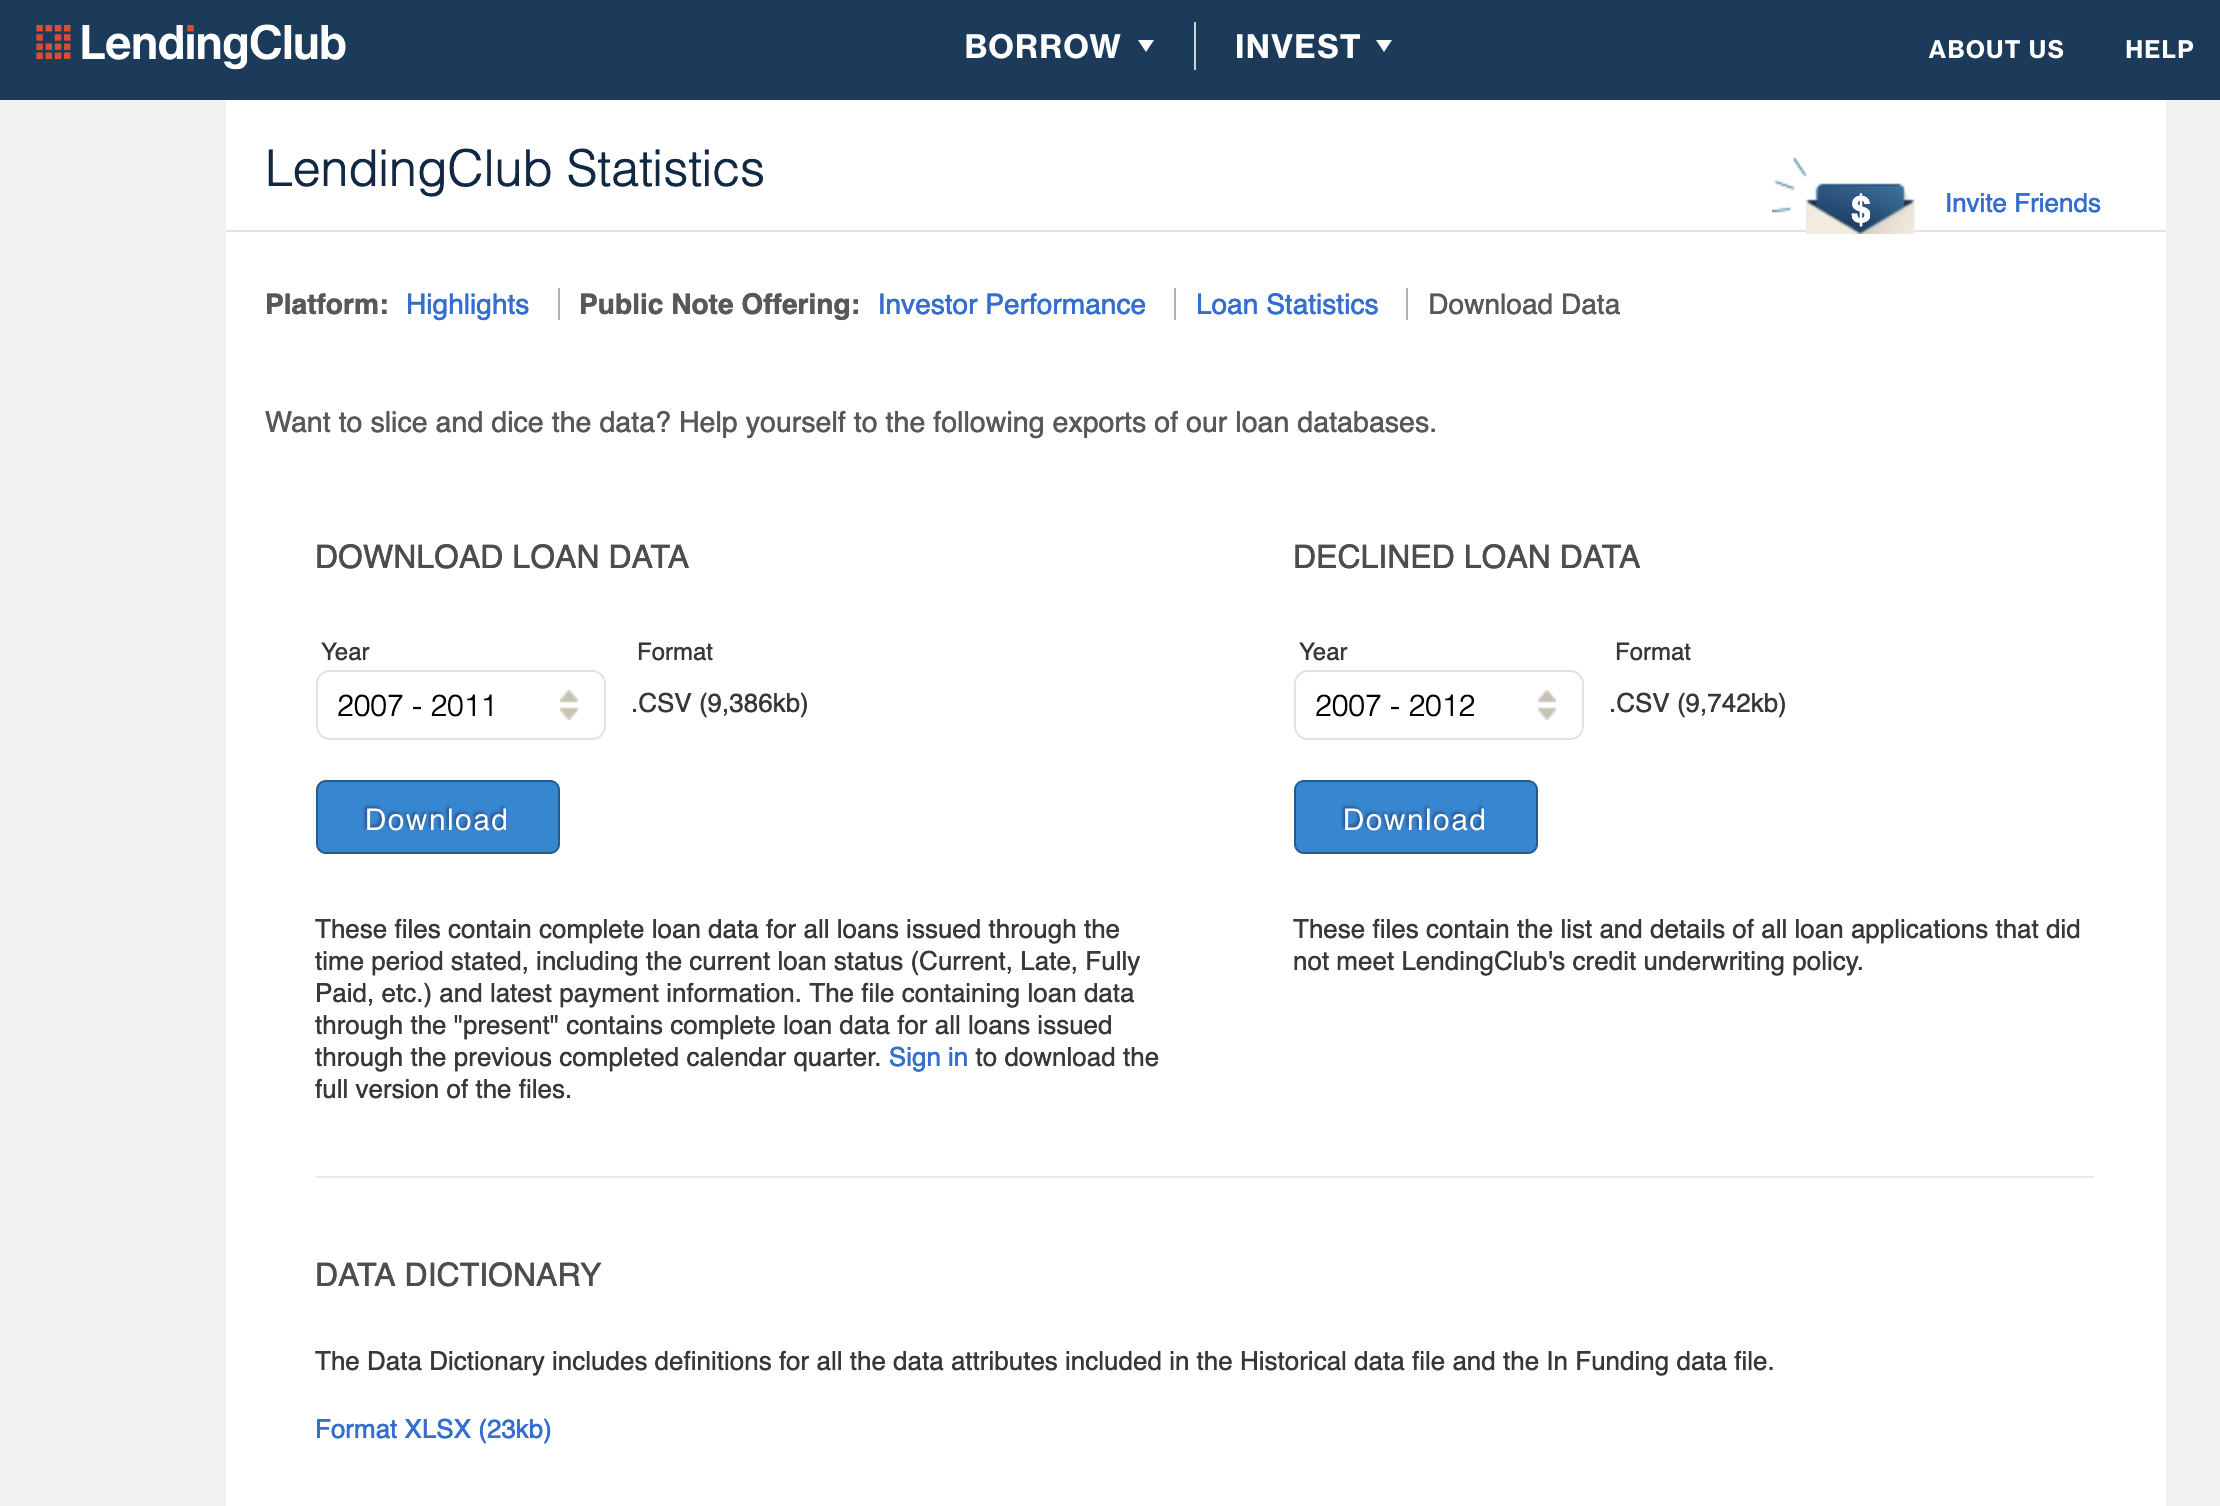

In [3]:
!rm LoanStats3a.csv.zip
!wget --no-check-certificate "https://resources.lendingclub.com/LoanStats3a.csv.zip"

--2019-03-26 20:11:16--  https://resources.lendingclub.com/LoanStats3a.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats3a.csv.zip’

LoanStats3a.csv.zip     [            <=>     ]   9.17M  2.08MB/s    in 4.5s    

2019-03-26 20:11:21 (2.02 MB/s) - ‘LoanStats3a.csv.zip’ saved [9610863]



### Data Dictionary - for Lending Club Data
We next display the data dictionary of the Lending Club Data. 

Note: Though there are 153 columns in the data dictionary, the actual data (in the next section) has only 145 columns

In [4]:
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth',9999)
pd.set_option('display.max_columns',9999)
pd.set_option('display.max_rows',9999)
data_dictionary = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

data_dictionary

LoanStatNew  \
0                                acc_now_delinq   
1                          acc_open_past_24mths   
2                                    addr_state   
3                                      all_util   
4                                    annual_inc   
5                              annual_inc_joint   
6                              application_type   
7                                   avg_cur_bal   
8                                bc_open_to_buy   
9                                       bc_util   
10                     chargeoff_within_12_mths   
11                      collection_recovery_fee   
12                   collections_12_mths_ex_med   
13                                  delinq_2yrs   
14                                  delinq_amnt   
15                                         desc   
16                                          dti   
17                                    dti_joint   
18                             earliest_cr_line   
19                                   emp_length   
20                                    emp_title   
21                              fico_range_high   
22                               fico_range_low   
23                                  funded_amnt   
24                              funded_amnt_inv   
25                                        grade   
26                               home_ownership   
27                                           id   
28                                      il_util   
29                          initial_list_status   
30                                       inq_fi   
31                                 inq_last_12m   
32                               inq_last_6mths   
33                                  installment   
34                                     int_rate   
35                                      issue_d   
36                           last_credit_pull_d   
37                         last_fico_range_high   
38                          last_fico_range_low   
39                              last_pymnt_amnt   
40                                 last_pymnt_d   
41                                    loan_amnt   
42                                  loan_status   
43                                   max_bal_bc   
44                                    member_id   
45                           mo_sin_old_il_acct   
46                         mo_sin_old_rev_tl_op   
47                        mo_sin_rcnt_rev_tl_op   
48                               mo_sin_rcnt_tl   
49                                     mort_acc   
50                       mths_since_last_delinq   
51                  mths_since_last_major_derog   
52                       mths_since_last_record   
53                           mths_since_rcnt_il   
54                         mths_since_recent_bc   
55                     mths_since_recent_bc_dlq   
56                        mths_since_recent_inq   
57               mths_since_recent_revol_delinq   
58                                 next_pymnt_d   
59                        num_accts_ever_120_pd   
60                               num_actv_bc_tl   
61                              num_actv_rev_tl   
62                                  num_bc_sats   
63                                    num_bc_tl   
64                                    num_il_tl   
65                                num_op_rev_tl   
66                                num_rev_accts   
67                          num_rev_tl_bal_gt_0   
68                                     num_sats   
69                             num_tl_120dpd_2m   
70                                 num_tl_30dpd   
71                           num_tl_90g_dpd_24m   
72                           num_tl_op_past_12m   
73                                     open_acc   
74                                  open_acc_6m   
75                                  open_il_12m   
76                                  open_il_24m   
77                                  open_act_il   
78     

### Munging the data in Pandas

We first read the data into a Pandas data frame. We skip reading the very first row as it has some non-header information. The target column **loan_status** has really 4 unique values, but as you can see below, it makes sense to fold them to 2 unique possibilities, **Fully Paid** and **Charged Off**, that makes it into a binary classification problem.

In [5]:
# Very first row has non-header data and hence skipping it. Read to a data frame

lc = pd.read_csv("LoanStats3a.csv.zip", skiprows=1,verbose=False, low_memory=False) 
lc.shape

(42538, 145)

In [6]:
# Normalize target column values for a simple binary classification problem

lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', lc['loan_status'])
lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', lc['loan_status'])

# Let's look at the unique values for the target col. Yes - it's a binary classification problem
lc.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan], dtype=object)

In [7]:
# Drop the columns from the data frame that are target leakage ones

ignored_cols = ['inq_last_6mths', 
                'out_prncp', 
                'out_prncp_inv', 
                'total_pymnt', 
                'total_pymnt_inv', 
                'total_rec_prncp', 
                'total_rec_int', 
                'total_rec_late_fee', 
                'recoveries', 
                'collection_recovery_fee', 
                'last_pymnt_d', 
                'last_pymnt_amnt', 
                'next_pymnt_d', 
                'last_credit_pull_d',
                ]

lc = lc.drop(columns=ignored_cols, axis = 1)

In [8]:
# After dropping Target Leakage columns, we have 42,538 rows and 131 columns
lc.shape

(42538, 131)

### Split to Train and Test - 80%/20%  and write it to two CSV files

In [9]:
import csv
import os 

train_path = os.getcwd() + "/train_lc.csv"
test_path = os.getcwd() + "/test_lc.csv"

train_lc, test_lc = model_selection.train_test_split(lc, test_size=0.2)
train_lc.to_csv(train_path, index=False)
test_lc.to_csv(test_path, index=False)


In [10]:
# Let's look at the shape of training data
train_lc.shape

(34030, 131)

In [11]:
# Let's look at the shape of test data

In [12]:
test_lc.shape

(8508, 131)

## Connect to H2O3 instance 


In [13]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(ip=h2o3_ip, strict_version_check=False)


Checking whether there is an H2O instance running at http://ec2-3-93-2-14.compute-1.amazonaws.com:54321. connected.


--------------------------  --------------------------------------------------
H2O cluster uptime:         7 mins 12 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.1.2
H2O cluster version age:    2 months and 8 days
H2O cluster name:           Puddle
H2O cluster total nodes:    1
H2O cluster free memory:    124.5 Gb
H2O cluster total cores:    40
H2O cluster allowed cores:  40
H2O cluster status:         locked, healthy
H2O connection url:         http://ec2-3-93-2-14.compute-1.amazonaws.com:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.0 final
--------------------------  --------------------------------------------------

### Upload the Train and Test data to Driverless AI

In [14]:
import os

# These two CSV files were created in the previous section

train_path = os.getcwd()+"/train_lc.csv"
test_path = os.getcwd()+ "/test_lc.csv"

train = h2o.load_dataset(train_path)
test = h2o.load_dataset(test_path)



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Run Auto ML


In [15]:
# Identify predictors and response
x = train.columns
y = "loan_status"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=5, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


### Look at AutoML Leaderboard

In [16]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id auc logloss mean_per_class_error rmse mse 
 
 
 StackedEnsemble_BestOfFamily_AutoML_20190327_031347 0.7067 0.38863 0.481294 0.343672 0.11811 
 StackedEnsemble_AllModels_AutoML_20190327_031347 0.706649 0.388704 0.480986 0.343722 0.118145 
 GLM_grid_1_AutoML_20190327_031347_model_1 0.705443 0.389728 0.488211 0.344661 0.118791 
 GBM_1_AutoML_20190327_031347 0.658136 0.407588 0.485495 0.35112 0.123285 
 GBM_2_AutoML_20190327_031347 0.657133 0.408773 0.487913 0.351633 0.123646 
 XRT_1_AutoML_20190327_031347 0.642969 0.404198 0.486521 0.349728 0.12231 
 DRF_1_AutoML_20190327_031347 0.616791 0.413012 0.486036 0.35218 0.124031

In [17]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190327_031347
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.10076111302527327
RMSE: 0.31742891019135805
LogLoss: 0.33399934911132306
Null degrees of freedom: 34026
Residual degrees of freedom: 34022
Null deviance: 28946.648973009113
Residual deviance: 22729.99170442198
AIC: 22739.99170442198
AUC: 0.8565856328244746
pr_auc: 0.9698278062636292
Gini: 0.7131712656489493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6426608469339741: 


Charged Off    Fully Paid    Error    Rate
-----------  -------------  ------------  -------  ----------------
Charged Off  1258           3898          0.756    (3898.0/5156.0)
Fully Paid   498            28373         0.0172   (498.0/28871.0)
Total        1756           32271         0.1292   (4396.0/34027.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.642661     0.928102  269
max f2                       0.334681     0.966728  354
max f0point5                 0.798341     0.915016  176
max accuracy                 0.660089     0.871191  261
max precision                0.950595     1         0
max recall                   0.162699     1         378
max specificity              0.950595     1         0
max absolute_mcc             0.798341     0.433123  176
max min_per_class_accuracy   0.837348     0.769783  140
max mean_per_class_accuracy  0.842862     0.773124  134

Gains/Lift Table: Avg response rate: 84.85 %, avg score: 84.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100215                   0.943987           1.17859   1.17859            1                0.945687  1                           0.945687            0.0118112       0.0118112                  17.8588   17.8588
    2        0.0200135                   0.942383           1.17859   1.17859            1                0.943138  1                           0.944414            0.0117765       0.0235877                  17.8588   17.8588
    3        0.0300056                   0.941177           1.17859   1.17859            1                0.941771  1                           0.943534            0.0117765       0.0353642                  17.8588   17.8588
    4        0.040027                    0.940059           1.17859   1.17859            1                0.940586  1                           0.942796            0.0118112       0.0471754                  17.8588   17.8588
    5        0.0500191                   0.939152           1.17859   1.17859            1                0.939603  1                           0.942158            0.0117765       0.0589519                  17.8588   17.8588
    6        0.100009                    0.934696           1.17859   1.17859            1                0.936913  1                           0.939536            0.0589173       0.117869                   17.8588   17.8588
    7        0.150028                    0.929743           1.1779    1.17836            0.999412         0.93228   0.999804                    0.937117            0.0589173       0.176786                   17.7895   17.8357
    8        0.200018                    0.923587           1.17027   1.17634            0.992945         0.926718  0.99809                     0.934518            0.0585016       0.235288                   17.0273   17.6336
    9        0.300026                    0.909754           1.16162   1.17143            0.985601         0.916858  0.993927                    0.928631            0.116172        0.35146                    16.1617   17.143
    10       0.400035                    0.894616           1.1353    1.1624             0.963268         0.90228   0.986262                    0.922043            0.11354         0.464999                   13.5295   16.2396
    11       0.500044                    0.878646           1.09685   1.14929            0.930649         0.886779  0.97514                     0.914991            0.109695        0.574694                   9.68518   14.9287
    12       0.600053                    0.859739           1.0643    1.13512            0.903027         0.869561  0.963121                    0.907419            0.106439        0.681133                   6.4296    13.5122
    13       0.700062                    0.833885           1.00611   1.11669            0.853659         0.847635  0.947483                    0.898879            0.10062         0.781753                   0.611129  11.6692
    14       0.799982                    0.793839           0.910286  1.09091            0.772353         0.815652  0.925609                    0.888483            0.0909563       0.87271                    -8.97145  9.09111
    15       0.899991                    0.719293           0.791036  1.05759            0.671172         0.762083  0.897335                    0.874437            0.0791105       0.95182                    -20.8964  5.75883
    16       1                           0.00965408         0.481756  1                  0.408757         0.586092  0.848473                    0.8456            



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1181101340345828
RMSE: 0.34367154964381735
LogLoss: 0.38863042742777854
Null degrees of freedom: 34026
Residual degrees of freedom: 34022
Null deviance: 28947.921724818734
Residual deviance: 26447.855108170035
AIC: 26457.855108170035
AUC: 0.7067004556718539
pr_auc: 0.9252419406971351
Gini: 0.4134009113437078
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35767950169576096: 


Charged Off    Fully Paid    Error    Rate
-----------  -------------  ------------  -------  ----------------
Charged Off  202            4954          0.9608   (4954.0/5156.0)
Fully Paid   51             28820         0.0018   (51.0/28871.0)
Total        253            33774         0.1471   (5005.0/34027.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35768      0.920105  352
max f2                       0.145767     0.966243  380
max f0point5                 0.676968     0.883009  254
max accuracy                 0.405183     0.852911  345
max precision                0.949494     1         0
max recall                   0.0814719    1         387
max specificity              0.949494     1         0
max absolute_mcc             0.844022     0.225376  133
max min_per_class_accuracy   0.86169      0.646625  113
max mean_per_class_accuracy  0.857176     0.649513  118

Gains/Lift Table: Avg response rate: 84.85 %, avg score: 84.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100215                   0.94387            1.16131   1.16131            0.985337         0.945574  0.985337                    0.945574            0.011638        0.011638                   16.1306   16.1306
    2        0.0200135                   0.942022           1.15779   1.15955            0.982353         0.942824  0.983847                    0.944201            0.0115687       0.0232067                  15.7789   15.955
    3        0.0300056                   0.94055            1.15779   1.15896            0.982353         0.941265  0.98335                     0.943223            0.0115687       0.0347754                  15.7789   15.8964
    4        0.040027                    0.939391           1.15439   1.15782            0.979472         0.939958  0.982379                    0.942406            0.0115687       0.0463441                  15.4394   15.7819
    5        0.0500191                   0.938265           1.14392   1.15504            0.970588         0.938821  0.980024                    0.94169             0.0114302       0.0577742                  14.3923   15.5043
    6        0.100009                    0.9331             1.12524   1.14014            0.954733         0.935673  0.967382                    0.938682            0.0562502       0.114024                   12.5236   14.0144
    7        0.150028                    0.927729           1.1225    1.13426            0.952409         0.930457  0.96239                     0.93594             0.0561463       0.170171                   12.2497   13.4261
    8        0.200018                    0.92184            1.10168   1.12612            0.934744         0.924851  0.95548                     0.933169            0.0550726       0.225243                   10.1678   12.6117
    9        0.300026                    0.908898           1.09131   1.11452            0.925948         0.915509  0.945636                    0.927282            0.109141        0.334384                   9.13104   11.4515
    10       0.400035                    0.895518           1.05391   1.09936            0.894211         0.902372  0.93278                     0.921054            0.1054          0.439784                   5.39059   9.93627
    11       0.500015                    0.880915           1.04313   1.08812            0.885068         0.888371  0.92324                     0.914519            0.104292        0.544075                   4.31296   8.81188
    12       0.599965                    0.862468           1.01051   1.07519            0.857395         0.871821  0.91227                     0.907406            0.101001        0.645076                   1.05149   7.51905
    13       0.699974                    0.837809           0.978751  1.06141            0.830444         0.850849  0.900579                    0.899325            0.0978837       0.74296                    -2.12494  6.14116
    14       0.799982                    0.800604           0.936497  1.0458             0.794593         0.820888  0.88733                     0.88952             0.093658        0.836618                   -6.35026  4.57956
    15       0.899991                    0.728423           0.882815  1.02768            0.749045         0.76938   0.871963                    0.876169            0.0882893       0.924907                   -11.7185  2.76849
    16       1                           0.00570937         0.75086   1                  0.637085         0.59944   0.848473                    0.848494          

### Print Training and Test Scores

In [18]:
test_pc = aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


/usr/local/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'emp_title' has levels not trained on: [0CEAN VIEW INTL REALTY/C21 UNITED PLATINUM, 101 restaurant, 1013 communications, 123 Recovery , 162 fighter wing, 1st Financial Bank, 2020 EyeCare, 20th Century Fox, 21 Fellowship, SBC, 21st Century Home Health Agency, 21st century oncology, 22squared, inc, 2800 Lake Shore Drive Comdominiun Associ, 2D LAR BN, USMC, 2Dialog, 2wire, 3 Phoenix Inc., 3550 Condo association, 3pl logistics inc, 5.11 Tactical, 5/3 Bank, 50 Below, 54th Street Grill  and  Bar, 7 Eleven Inc, 72andSunny, 7UP BOTTLING, 92nd St Y, A Major Research University, A Running Start, A Work of Faith Community Outreach Corp, A&A Sheetmetal Contractors Corp., A-1 Budget Plumbing, A-L Service, A.C.U.A., AAA Cooper Transportation, AAA East Central, AAA Laser Service & Supplies , AANEM, AASHE, AB Tech Community College, ABB  Inc, ABC Court Reporting, ABC/Disney, Inc., ABF Freight systms, ABM 

/usr/local/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'title' has levels not trained on: ["Get Out of Debt", $10,000 NEEDED, $10,000 needed for wedding, $15K, $20,000 paid in 36 months, '08 & '09 Roth IRA Investments, '71 Bobbed Duece, +++ Credit Consolidation Loan, 02 celica, 05' Hyundai Sonata , 08/23/11 $6,000, 081810 Personal Loan $14k, 09-2011 Debt Consolidation, 1 Williams Inc., 10/10, 100% Guaranteed Loan, Great Credit Score, 100% ontime payment history 95K W2 verifiable income pay off colleg creditcards, 10K Dec 2010 Loan, 1166 Home Improvement, 12,000, 12K loan, will pay back within 10 months, 13K in 26 mnts, 147 Sit st., 1500 loan, 15K LOAN, 18K Consolidation, 1941 Chevrolet 3100, 1948 Chev, 1948 international, 1957 Chevy Pick up, 1969 mustang restoration, 1970 Dodge Charger, 1994 Chevy Tahoe, 1998 Chevelet Camaro, 1999 BMW M3, 1999 Suzuki GSXR 600, 1FBUSA Credit Card Refinance, 1ST STEP, 1st Financial APRs WAY too high! :-), 1st Lo

/usr/local/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'zip_code' has levels not trained on: [266xx, 385xx, 388xx, 390xx, 408xx, 465xx, 469xx, 473xx, 556xx, 738xx, 747xx, 772xx, 999xx]
  warnings.warn(w)


In [19]:
test_pc

predict Charged Off Fully Paid 
 
 
 Fully Paid 0.104082 0.895918 
 Fully Paid 0.357745 0.642255 
 Fully Paid 0.0582881 0.941712 
 Fully Paid 0.0821737 0.917826 
 Fully Paid 0.141502 0.858498 
 Fully Paid 0.098167 0.901833 
 Fully Paid 0.11627 0.88373 
 Fully Paid 0.241146 0.758854 
 Fully Paid 0.0826793 0.917321 
 Fully Paid 0.298017 0.701983

In [22]:
aml.leader.model_performance(test_data=test).auc()

0.7200782361887103